In [2]:
import lightkurve as lk
import numpy as np

def download_sector(tic_id, author="SPOC"):
    search = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author=author)
    tbl = search.table

    data = {}

    # 找出所有 sector
    sectors = np.unique(tbl["sequence_number"])  # 有些版本是 "sector" 或 "sequence_number"

    for sec in sectors:
        # 取出这个 sector 的所有行
        mask = tbl["sequence_number"] == sec
        sub = tbl[mask]

        # 在这个 sector 中选 exptime 最小的一条
        best_idx = np.argmin(sub["exptime"])
        row = search[mask][best_idx]

        exptime = sub["exptime"][best_idx]
        print(f"Downloading TIC {tic_id} Sector {sec} (exptime={exptime}s) ...")

        lc = (row.download(flux_column="pdcsap_flux")
                .remove_nans()
                .normalize())

        key = (int(sec), float(exptime))
        data[key] = lc

    return data

sector_data = download_sector(29857954)



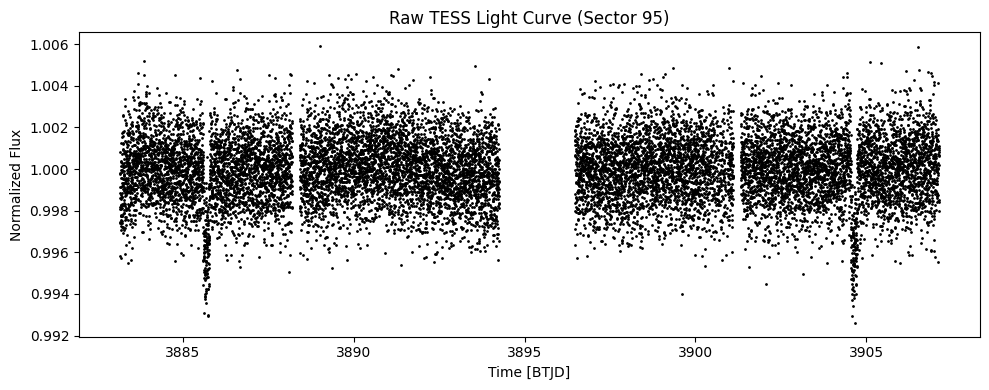

global sigma = 0.0015682571101933718 prominence min = 0.004704771330580115
找到的候选谷值个数: 38
候选时间: [3883.38874592 3883.99292182 3884.7609878  3885.22488223 3885.73460987
 3886.24155904 3886.67628478 3887.21239956 3887.64017975 3888.09712627
 3888.75129501 3889.3624071  3889.79296278 3890.37629555 3890.90407209
 3891.39018144 3891.91101222 3892.33462075 3892.77628425 3893.42488989
 3894.20682685 3897.0359754  3897.78041406 3898.43874107 3899.02901222
 3899.60261603 3900.28177297 3900.89565208 3901.58175116 3902.06785304
 3902.68450715 3903.14977484 3903.84559207 3904.68445992 3905.18027998
 3905.99275692 3906.59690551 3907.08855715]
Transit candidates: 3885.7346098721328 3904.6844599190654


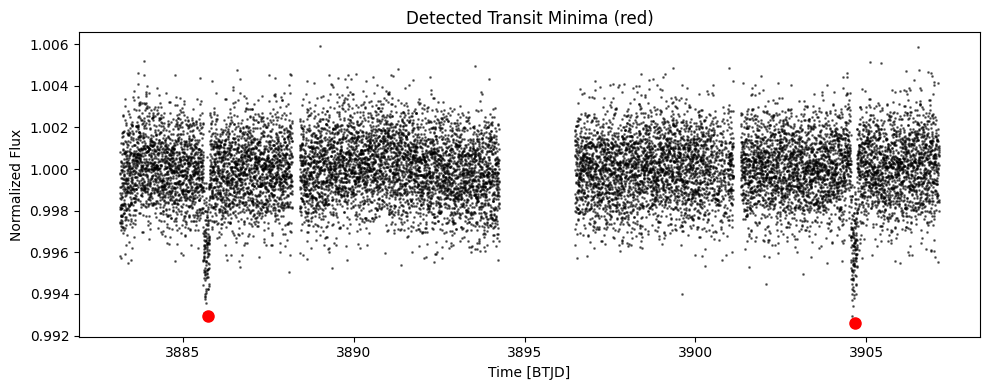

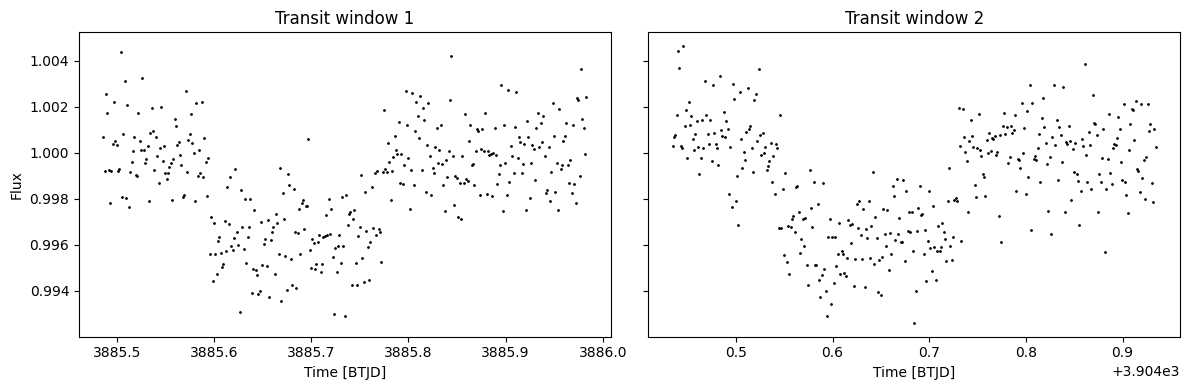

Fitting transit 1 ...


sample: 100%|██████████| 3500/3500 [00:50<00:00, 68.98it/s, 127 steps of size 4.05e-02. acc. prob=0.93] 


Posterior summary:
  t0        = 3885.903349 ± 0.009149
  duration  = 0.2989 ± 0.0236 days
  r (Rp/R*) = 0.0774 ± 0.0045
  b         = 0.4670 ± 0.2356
  c0        = 0.9961 ± 0.0003
  c1        = -0.0152 ± 0.0020
  sigma_jit = 0.00026 ± 0.00011
----------------------------------------

Fitting transit 2 ...


sample: 100%|██████████| 3500/3500 [00:41<00:00, 84.47it/s, 63 steps of size 4.75e-02. acc. prob=0.91]  


Posterior summary:
  t0        = 3904.856127 ± 0.009488
  duration  = 0.2925 ± 0.0247 days
  r (Rp/R*) = 0.0816 ± 0.0045
  b         = 0.4540 ± 0.2359
  c0        = 0.9960 ± 0.0003
  c1        = -0.0186 ± 0.0020
  sigma_jit = 0.00027 ± 0.00011
----------------------------------------

Transit 1 center time: 3885.903349 ± 0.009149
Transit 2 center time: 3904.856127 ± 0.009488
Difference (approx period): 18.952778 days


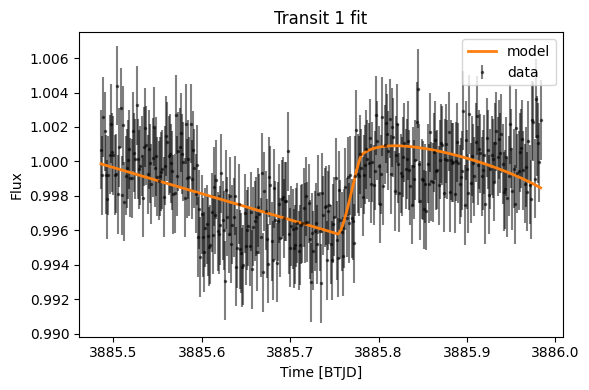

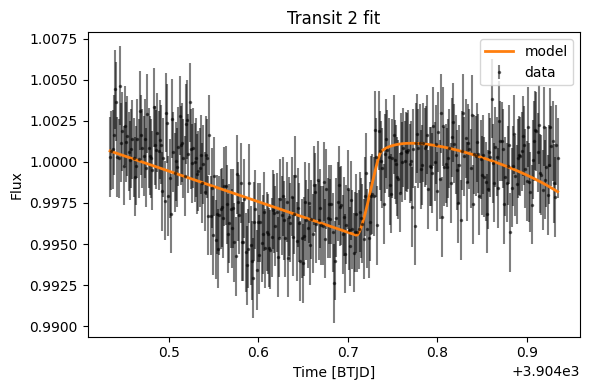

In [11]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

# JAX 设置
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# ============================================
# 1. 取出 Sector 95 的真实光变
#    注意：download_sector 里 key 是 (sector, exptime)
# ============================================
lc = sector_data[(95, 120.0)]   # 如果 exptime 不是 120.0，这里改掉

time_np = lc.time.value       # BTJD
flux_np = lc.flux.value       # normalized flux

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 95)")
plt.tight_layout()
plt.show()

# ============================================
# 2. 用 prominence 找两个“最明显”的 transit 谷值
# ============================================
inv_flux = 1.0 - flux_np
sigma_all = float(np.std(flux_np))
prom_min = 3.0 * sigma_all

print("global sigma =", sigma_all, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=300,          # 两个 transit 至少隔这么多点
    prominence=prom_min    # 至少比周围高出 3σ
)

print("找到的候选谷值个数:", len(peaks))
print("候选时间:", time_np[peaks])

# 如果候选太少，自动放宽阈值
if len(peaks) < 2:
    prom_min = 2.0 * sigma_all
    print("候选 < 2，放宽 prominence 到", prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=300,
        prominence=prom_min
    )
    print("新的候选个数:", len(peaks))
    print("新的候选时间:", time_np[peaks])

# 取 prominence 最大的两个（"prominences" 注意 s）
prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

# 可视化
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()

# ============================================
# 3. 按中心时间裁剪每个 transit 附近的一小段光变
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.25):
    """在 t_center 前后 window 天内裁剪光变."""
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc   # 把局部 std 当成名义误差
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.25)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.25)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()

# ============================================
# 4. 局部 transit 模型：transit + 很小的线性 baseline + jitter
#    参数：t0, duration, r, b, (固定 u1,u2), c0, c1, jitter
# ============================================
def transit_model_local(t, yerr, y=None):
    # t0：以局部窗口平均时间为中心
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.03))

    # duration：log-uniform 先验（0.08–0.35 d）
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.08), jnp.log(0.35)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # r: 半径比（不太可能 >0.25）
    r = numpyro.sample("r", dist.Uniform(0.02, 0.25))

    # b: impact parameter，避免 grazing，但也不要太死
    b = numpyro.sample("b", dist.Uniform(0.0, 0.8))

    # limb darkening：先固定成一个合理值，减少退化
    u1 = numpyro.deterministic("u1", 0.3)
    u2 = numpyro.deterministic("u2", 0.2)
    u = jnp.array([u1, u2])

    # 轨道：period=10 只是 dummy，用 duration/t0/b/r 控制形状
    orbit = TransitOrbit(
        period=10.0,
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # limb_dark_light_curve 返回的是“被遮挡的光”(occultation)
    occultation = limb_dark_light_curve(orbit, u)(t)
    flux_tr = 1.0 - occultation

    # 很小的线性 baseline：c0 + c1*(t - t_center)
    t_center = t.mean()
    c0 = numpyro.sample("c0", dist.Normal(1.0, 0.005))
    c1 = numpyro.sample("c1", dist.Normal(0.0, 0.02))   # 斜率非常小
    baseline = c0 + c1 * (t - t_center)

    model = baseline * flux_tr

    # ========= jitter term =========
    med_err = jnp.median(yerr)
    log_sigma_jit = numpyro.sample(
        "log_sigma_jit",
        dist.Normal(jnp.log(med_err + 1e-8), 1.0)
    )
    sigma_jit = numpyro.deterministic("sigma_jit", jnp.exp(log_sigma_jit))
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)

    numpyro.sample("obs", dist.Normal(model, sigma_tot), obs=y)

# ============================================
# 5. 拟合函数：返回 posterior 统计量 + samples
# ============================================
def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2500, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    def mean_std(name):
        arr = np.array(samples[name])
        return float(arr.mean()), float(arr.std())

    t0_mean, t0_std = mean_std("t0")
    D_mean,  D_std  = mean_std("duration")
    r_mean,  r_std  = mean_std("r")
    b_mean,  b_std  = mean_std("b")
    c0_mean, c0_std = mean_std("c0")
    c1_mean, c1_std = mean_std("c1")
    sj_mean, sj_std = mean_std("sigma_jit")

    print("Posterior summary:")
    print(f"  t0        = {t0_mean:.6f} ± {t0_std:.6f}")
    print(f"  duration  = {D_mean:.4f} ± {D_std:.4f} days")
    print(f"  r (Rp/R*) = {r_mean:.4f} ± {r_std:.4f}")
    print(f"  b         = {b_mean:.4f} ± {b_std:.4f}")
    print(f"  c0        = {c0_mean:.4f} ± {c0_std:.4f}")
    print(f"  c1        = {c1_mean:.4f} ± {c1_std:.4f}")
    print(f"  sigma_jit = {sj_mean:.5f} ± {sj_std:.5f}")
    print("-" * 40)

    summary = dict(
        t0_mean=t0_mean, t0_std=t0_std,
        duration_mean=D_mean, duration_std=D_std,
        r_mean=r_mean, r_std=r_std,
        b_mean=b_mean, b_std=b_std,
        c0_mean=c0_mean, c0_std=c0_std,
        c1_mean=c1_mean, c1_std=c1_std,
        sigma_jit_mean=sj_mean, sigma_jit_std=sj_std,
    )
    return summary, samples

# ============================================
# 6. 分别拟合两次 transit 的中心时间 & 形状参数
# ============================================
print("Fitting transit 1 ...")
summary1, samples1 = fit_t0(t1, f1, e1, seed=1)

print("\nFitting transit 2 ...")
summary2, samples2 = fit_t0(t2, f2, e2, seed=2)

t0_1 = summary1["t0_mean"]
t0_2 = summary2["t0_mean"]
t0_1_std = summary1["t0_std"]
t0_2_std = summary2["t0_std"]

print("\n==============================")
print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")
print("==============================")

# ============================================
# 7. 画一下每次拟合的局部 fit
# ============================================
def plot_fit(time_array, flux_array, t0_fit, samples, title):
    t = jnp.array(time_array)
    f = flux_array

    D_post  = float(np.mean(np.array(samples["duration"])))
    r_post  = float(np.mean(np.array(samples["r"])))
    b_post  = float(np.mean(np.array(samples["b"])))
    c0_post = float(np.mean(np.array(samples["c0"])))
    c1_post = float(np.mean(np.array(samples["c1"])))

    # limb darkening 固定
    u_post  = jnp.array([0.3, 0.2])

    orbit = TransitOrbit(
        period=10.0,
        duration=D_post,
        time_transit=t0_fit,
        impact_param=b_post,
        radius_ratio=r_post,
    )

    occultation = limb_dark_light_curve(orbit, u_post)(t)
    flux_tr = 1.0 - occultation

    t_center = t.mean()
    baseline = c0_post + c1_post * (t - t_center)

    model = np.array(baseline * flux_tr)

    plt.figure(figsize=(6,4))
    plt.errorbar(time_array, flux_array,
                 yerr=np.std(flux_array),
                 fmt=".k", ms=3, alpha=0.5, label="data")
    plt.plot(time_array, model, "-C1", lw=2, label="model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fit(t1, f1, t0_1, samples1, "Transit 1 fit")
plot_fit(t2, f2, t0_2, samples2, "Transit 2 fit")


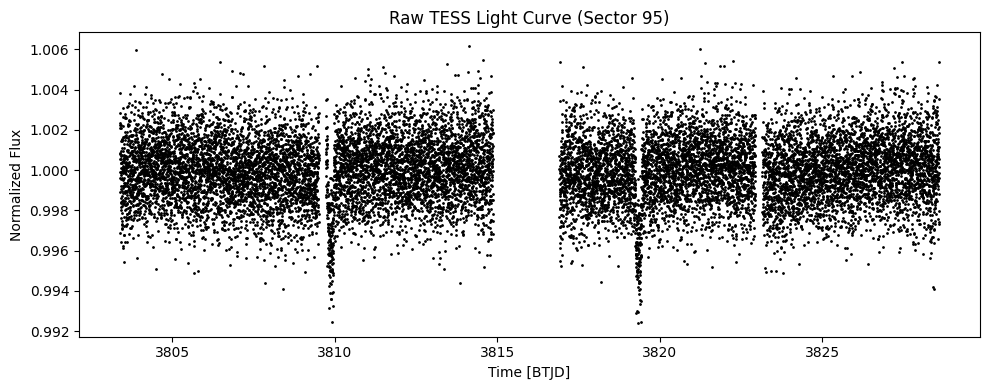

global sigma = 0.0016291119391098619 prominence min = 0.0048873358173295856
找到的候选谷值个数: 42
候选时间: [3803.50866037 3803.93648095 3804.48931425 3805.09770852 3805.65331938
 3806.20754082 3806.77981917 3807.26319958 3807.86603563 3808.42025545
 3809.09531968 3809.91484133 3810.35238222 3810.85381767 3811.29552511
 3811.73167624 3812.37479039 3812.82899814 3813.35404536 3813.85409006
 3814.57915457 3817.07104834 3817.60998851 3818.20865659 3818.71564901
 3819.34209668 3819.94354142 3820.42414118 3820.84779095 3821.62147191
 3822.35070354 3823.28134079 3823.79805222 3824.28559408 3824.84397489
 3825.26206567 3825.74682839 3826.39966012 3826.88581098 3827.36501649
 3827.8720017  3828.43176865]
Transit candidates: 3809.9148413333896 3819.342096677204


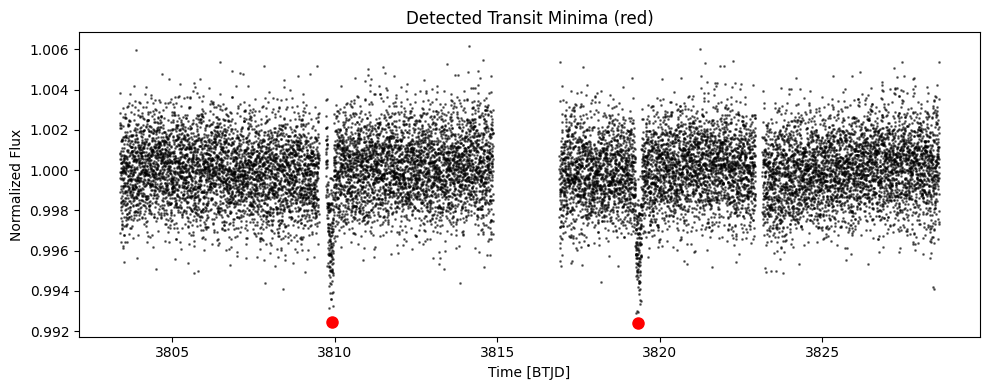

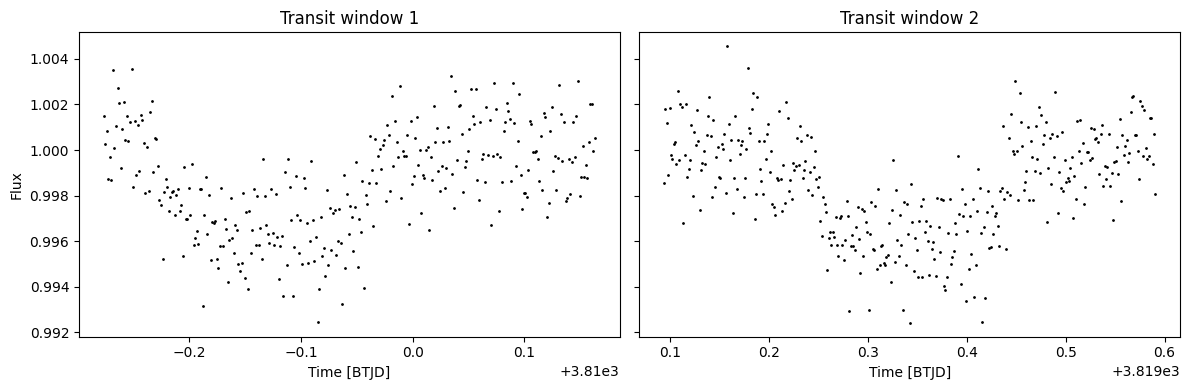

Fitting transit 1 ...


sample: 100%|██████████| 3500/3500 [00:47<00:00, 74.27it/s, 127 steps of size 3.77e-02. acc. prob=0.95] 


Posterior summary:
  t0        = 3809.743200 ± 0.007072
  duration  = 0.0950 ± 0.0135 days
  r (Rp/R*) = 0.0682 ± 0.0043
  b         = 0.5066 ± 0.2379
  c0        = 0.9979 ± 0.0002
  c1        = 0.0134 ± 0.0014
  sigma_jit = 0.00027 ± 0.00012
----------------------------------------

Fitting transit 2 ...


sample: 100%|██████████| 3500/3500 [00:44<00:00, 79.32it/s, 63 steps of size 4.02e-02. acc. prob=0.93]  


Posterior summary:
  t0        = 3819.530712 ± 0.008013
  duration  = 0.2224 ± 0.0213 days
  r (Rp/R*) = 0.0765 ± 0.0039
  b         = 0.4996 ± 0.2333
  c0        = 0.9966 ± 0.0002
  c1        = -0.0157 ± 0.0016
  sigma_jit = 0.00024 ± 0.00010
----------------------------------------

Transit 1 center time: 3809.743200 ± 0.007072
Transit 2 center time: 3819.530712 ± 0.008013
Difference (approx period): 9.787512 days


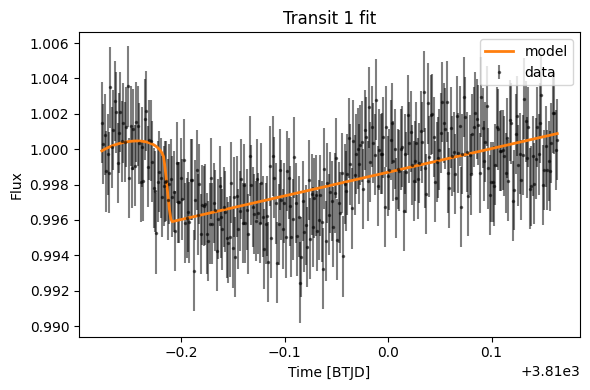

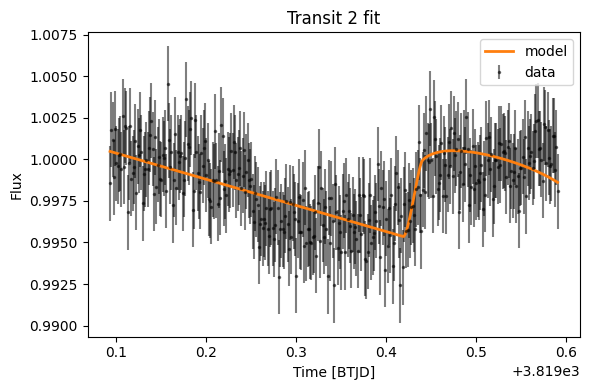

In [12]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

# JAX 设置
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# ============================================
# 1. 取出 Sector 95 的真实光变
#    注意：download_sector 里 key 是 (sector, exptime)
# ============================================
lc = sector_data[(92, 120.0)]   # 如果 exptime 不是 120.0，这里改掉

time_np = lc.time.value       # BTJD
flux_np = lc.flux.value       # normalized flux

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 95)")
plt.tight_layout()
plt.show()

# ============================================
# 2. 用 prominence 找两个“最明显”的 transit 谷值
# ============================================
inv_flux = 1.0 - flux_np
sigma_all = float(np.std(flux_np))
prom_min = 3.0 * sigma_all

print("global sigma =", sigma_all, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=300,          # 两个 transit 至少隔这么多点
    prominence=prom_min    # 至少比周围高出 3σ
)

print("找到的候选谷值个数:", len(peaks))
print("候选时间:", time_np[peaks])

# 如果候选太少，自动放宽阈值
if len(peaks) < 2:
    prom_min = 2.0 * sigma_all
    print("候选 < 2，放宽 prominence 到", prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=300,
        prominence=prom_min
    )
    print("新的候选个数:", len(peaks))
    print("新的候选时间:", time_np[peaks])

# 取 prominence 最大的两个（"prominences" 注意 s）
prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

# 可视化
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()

# ============================================
# 3. 按中心时间裁剪每个 transit 附近的一小段光变
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.25):
    """在 t_center 前后 window 天内裁剪光变."""
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc   # 把局部 std 当成名义误差
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.25)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.25)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()

# ============================================
# 4. 局部 transit 模型：transit + 很小的线性 baseline + jitter
#    参数：t0, duration, r, b, (固定 u1,u2), c0, c1, jitter
# ============================================
def transit_model_local(t, yerr, y=None):
    # t0：以局部窗口平均时间为中心
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.03))

    # duration：log-uniform 先验（0.08–0.35 d）
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.08), jnp.log(0.35)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # r: 半径比（不太可能 >0.25）
    r = numpyro.sample("r", dist.Uniform(0.02, 0.25))

    # b: impact parameter，避免 grazing，但也不要太死
    b = numpyro.sample("b", dist.Uniform(0.0, 0.8))

    # limb darkening：先固定成一个合理值，减少退化
    u1 = numpyro.deterministic("u1", 0.3)
    u2 = numpyro.deterministic("u2", 0.2)
    u = jnp.array([u1, u2])

    # 轨道：period=10 只是 dummy，用 duration/t0/b/r 控制形状
    orbit = TransitOrbit(
        period=10.0,
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # limb_dark_light_curve 返回的是“被遮挡的光”(occultation)
    occultation = limb_dark_light_curve(orbit, u)(t)
    flux_tr = 1.0 - occultation

    # 很小的线性 baseline：c0 + c1*(t - t_center)
    t_center = t.mean()
    c0 = numpyro.sample("c0", dist.Normal(1.0, 0.005))
    c1 = numpyro.sample("c1", dist.Normal(0.0, 0.02))   # 斜率非常小
    baseline = c0 + c1 * (t - t_center)

    model = baseline * flux_tr

    # ========= jitter term =========
    med_err = jnp.median(yerr)
    log_sigma_jit = numpyro.sample(
        "log_sigma_jit",
        dist.Normal(jnp.log(med_err + 1e-8), 1.0)
    )
    sigma_jit = numpyro.deterministic("sigma_jit", jnp.exp(log_sigma_jit))
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)

    numpyro.sample("obs", dist.Normal(model, sigma_tot), obs=y)

# ============================================
# 5. 拟合函数：返回 posterior 统计量 + samples
# ============================================
def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2500, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    def mean_std(name):
        arr = np.array(samples[name])
        return float(arr.mean()), float(arr.std())

    t0_mean, t0_std = mean_std("t0")
    D_mean,  D_std  = mean_std("duration")
    r_mean,  r_std  = mean_std("r")
    b_mean,  b_std  = mean_std("b")
    c0_mean, c0_std = mean_std("c0")
    c1_mean, c1_std = mean_std("c1")
    sj_mean, sj_std = mean_std("sigma_jit")

    print("Posterior summary:")
    print(f"  t0        = {t0_mean:.6f} ± {t0_std:.6f}")
    print(f"  duration  = {D_mean:.4f} ± {D_std:.4f} days")
    print(f"  r (Rp/R*) = {r_mean:.4f} ± {r_std:.4f}")
    print(f"  b         = {b_mean:.4f} ± {b_std:.4f}")
    print(f"  c0        = {c0_mean:.4f} ± {c0_std:.4f}")
    print(f"  c1        = {c1_mean:.4f} ± {c1_std:.4f}")
    print(f"  sigma_jit = {sj_mean:.5f} ± {sj_std:.5f}")
    print("-" * 40)

    summary = dict(
        t0_mean=t0_mean, t0_std=t0_std,
        duration_mean=D_mean, duration_std=D_std,
        r_mean=r_mean, r_std=r_std,
        b_mean=b_mean, b_std=b_std,
        c0_mean=c0_mean, c0_std=c0_std,
        c1_mean=c1_mean, c1_std=c1_std,
        sigma_jit_mean=sj_mean, sigma_jit_std=sj_std,
    )
    return summary, samples

# ============================================
# 6. 分别拟合两次 transit 的中心时间 & 形状参数
# ============================================
print("Fitting transit 1 ...")
summary1, samples1 = fit_t0(t1, f1, e1, seed=1)

print("\nFitting transit 2 ...")
summary2, samples2 = fit_t0(t2, f2, e2, seed=2)

t0_1 = summary1["t0_mean"]
t0_2 = summary2["t0_mean"]
t0_1_std = summary1["t0_std"]
t0_2_std = summary2["t0_std"]

print("\n==============================")
print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")
print("==============================")

# ============================================
# 7. 画一下每次拟合的局部 fit
# ============================================
def plot_fit(time_array, flux_array, t0_fit, samples, title):
    t = jnp.array(time_array)
    f = flux_array

    D_post  = float(np.mean(np.array(samples["duration"])))
    r_post  = float(np.mean(np.array(samples["r"])))
    b_post  = float(np.mean(np.array(samples["b"])))
    c0_post = float(np.mean(np.array(samples["c0"])))
    c1_post = float(np.mean(np.array(samples["c1"])))

    # limb darkening 固定
    u_post  = jnp.array([0.3, 0.2])

    orbit = TransitOrbit(
        period=10.0,
        duration=D_post,
        time_transit=t0_fit,
        impact_param=b_post,
        radius_ratio=r_post,
    )

    occultation = limb_dark_light_curve(orbit, u_post)(t)
    flux_tr = 1.0 - occultation

    t_center = t.mean()
    baseline = c0_post + c1_post * (t - t_center)

    model = np.array(baseline * flux_tr)

    plt.figure(figsize=(6,4))
    plt.errorbar(time_array, flux_array,
                 yerr=np.std(flux_array),
                 fmt=".k", ms=3, alpha=0.5, label="data")
    plt.plot(time_array, model, "-C1", lw=2, label="model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fit(t1, f1, t0_1, samples1, "Transit 1 fit")
plot_fit(t2, f2, t0_2, samples2, "Transit 2 fit")


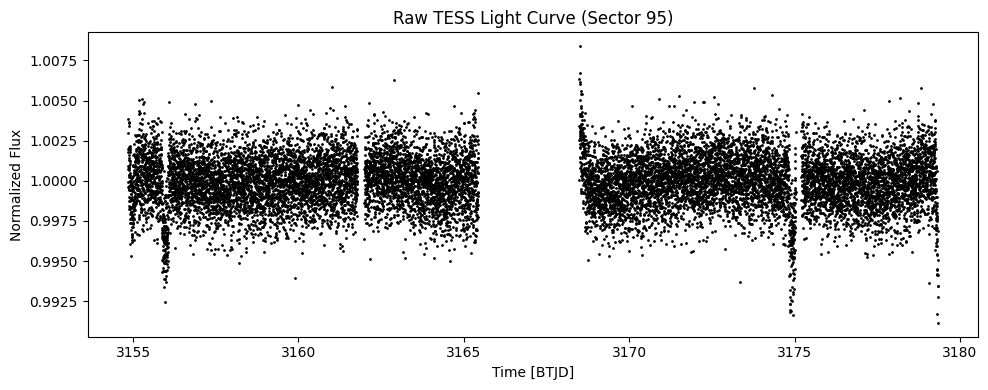

global sigma = 0.0016355710104107857 prominence min = 0.004906713031232357
找到的候选谷值个数: 39
候选时间: [3154.94786337 3155.43536992 3155.9534311  3156.81593749 3157.45344029
 3158.19094196 3158.96733109 3159.41594173 3159.89788522 3160.33399508
 3160.78538231 3161.35899083 3162.15620858 3162.68953841 3163.20620133
 3163.68397536 3164.10758294 3164.58813429 3165.20479534 3168.73948818
 3169.3880928  3169.9269746  3170.40057835 3170.92556919 3171.34222794
 3171.85332867 3172.32831843 3172.91024963 3173.35190578 3173.79217269
 3174.35188059 3174.94769809 3175.78517489 3176.2948825  3176.71153696
 3177.17957856 3177.84066955 3178.54620321 3179.31979003]
Transit candidates: 3155.953431104642 3174.9476980889576


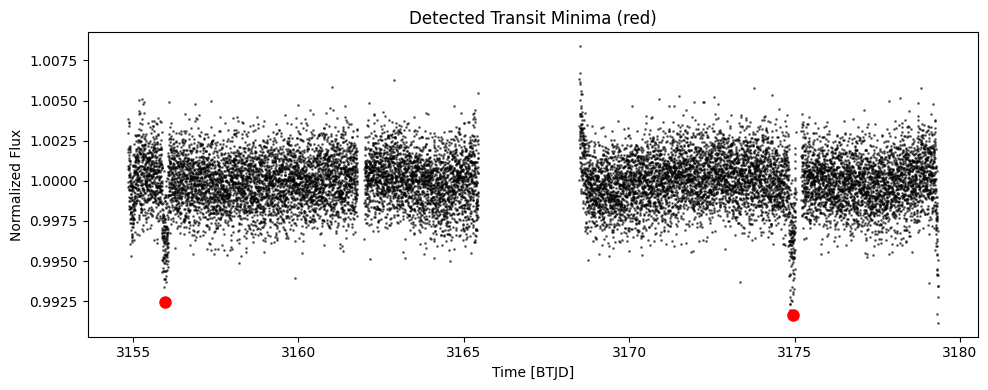

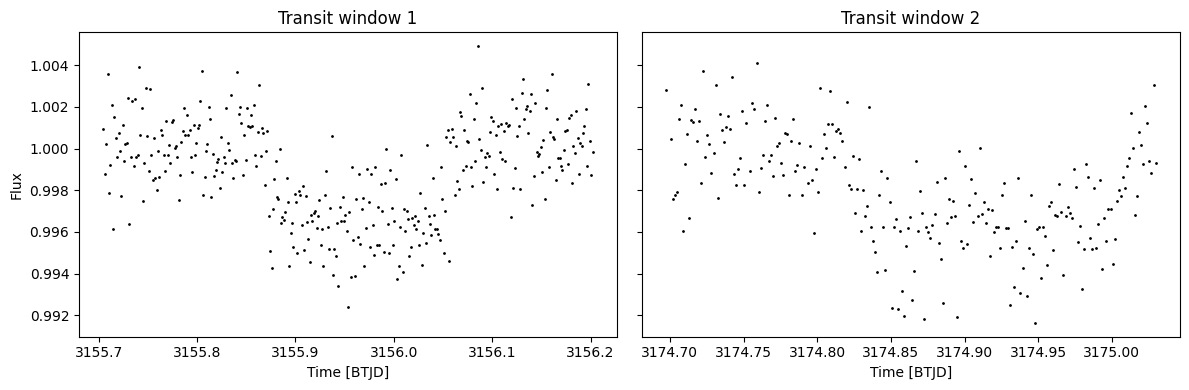

Fitting transit 1 ...


sample: 100%|██████████| 3500/3500 [00:49<00:00, 71.25it/s, 191 steps of size 4.15e-02. acc. prob=0.93] 


Posterior summary:
  t0        = 3155.773732 ± 0.008318
  duration  = 0.2369 ± 0.0251 days
  r (Rp/R*) = 0.0783 ± 0.0043
  b         = 0.5601 ± 0.2260
  c0        = 0.9968 ± 0.0002
  c1        = 0.0165 ± 0.0017
  sigma_jit = 0.00026 ± 0.00011
----------------------------------------

Fitting transit 2 ...


sample: 100%|██████████| 3500/3500 [00:29<00:00, 117.07it/s, 63 steps of size 5.68e-02. acc. prob=0.93] 


Posterior summary:
  t0        = 3174.751655 ± 0.008836
  duration  = 0.1808 ± 0.0231 days
  r (Rp/R*) = 0.0719 ± 0.0060
  b         = 0.4669 ± 0.2399
  c0        = 0.9958 ± 0.0004
  c1        = 0.0110 ± 0.0039
  sigma_jit = 0.00034 ± 0.00015
----------------------------------------

Transit 1 center time: 3155.773732 ± 0.008318
Transit 2 center time: 3174.751655 ± 0.008836
Difference (approx period): 18.977922 days


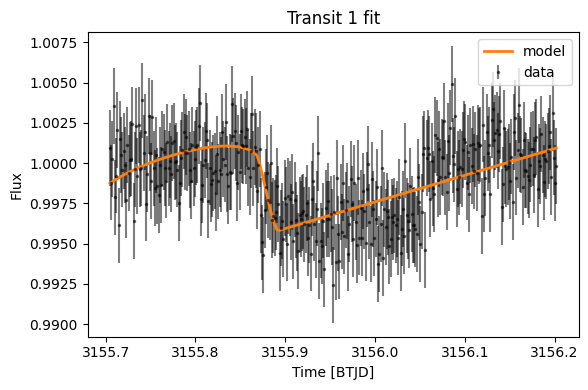

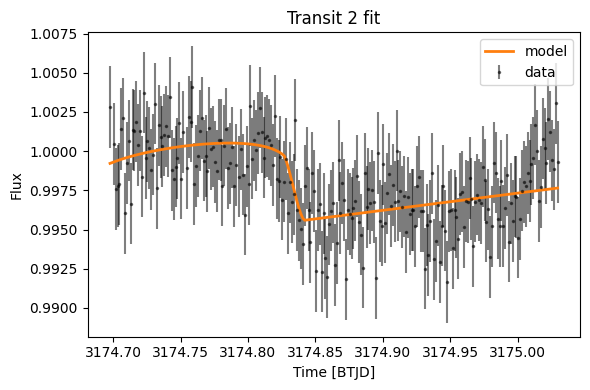

In [13]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

# JAX 设置
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# ============================================
# 1. 取出 Sector 95 的真实光变
#    注意：download_sector 里 key 是 (sector, exptime)
# ============================================
lc = sector_data[(68, 120.0)]   # 如果 exptime 不是 120.0，这里改掉

time_np = lc.time.value       # BTJD
flux_np = lc.flux.value       # normalized flux

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 95)")
plt.tight_layout()
plt.show()

# ============================================
# 2. 用 prominence 找两个“最明显”的 transit 谷值
# ============================================
inv_flux = 1.0 - flux_np
sigma_all = float(np.std(flux_np))
prom_min = 3.0 * sigma_all

print("global sigma =", sigma_all, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=300,          # 两个 transit 至少隔这么多点
    prominence=prom_min    # 至少比周围高出 3σ
)

print("找到的候选谷值个数:", len(peaks))
print("候选时间:", time_np[peaks])

# 如果候选太少，自动放宽阈值
if len(peaks) < 2:
    prom_min = 2.0 * sigma_all
    print("候选 < 2，放宽 prominence 到", prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=300,
        prominence=prom_min
    )
    print("新的候选个数:", len(peaks))
    print("新的候选时间:", time_np[peaks])

# 取 prominence 最大的两个（"prominences" 注意 s）
prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

# 可视化
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()

# ============================================
# 3. 按中心时间裁剪每个 transit 附近的一小段光变
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.25):
    """在 t_center 前后 window 天内裁剪光变."""
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc   # 把局部 std 当成名义误差
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.25)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.25)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()

# ============================================
# 4. 局部 transit 模型：transit + 很小的线性 baseline + jitter
#    参数：t0, duration, r, b, (固定 u1,u2), c0, c1, jitter
# ============================================
def transit_model_local(t, yerr, y=None):
    # t0：以局部窗口平均时间为中心
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.03))

    # duration：log-uniform 先验（0.08–0.35 d）
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.08), jnp.log(0.35)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # r: 半径比（不太可能 >0.25）
    r = numpyro.sample("r", dist.Uniform(0.02, 0.25))

    # b: impact parameter，避免 grazing，但也不要太死
    b = numpyro.sample("b", dist.Uniform(0.0, 0.8))

    # limb darkening：先固定成一个合理值，减少退化
    u1 = numpyro.deterministic("u1", 0.3)
    u2 = numpyro.deterministic("u2", 0.2)
    u = jnp.array([u1, u2])

    # 轨道：period=10 只是 dummy，用 duration/t0/b/r 控制形状
    orbit = TransitOrbit(
        period=10.0,
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # limb_dark_light_curve 返回的是“被遮挡的光”(occultation)
    occultation = limb_dark_light_curve(orbit, u)(t)
    flux_tr = 1.0 - occultation

    # 很小的线性 baseline：c0 + c1*(t - t_center)
    t_center = t.mean()
    c0 = numpyro.sample("c0", dist.Normal(1.0, 0.005))
    c1 = numpyro.sample("c1", dist.Normal(0.0, 0.02))   # 斜率非常小
    baseline = c0 + c1 * (t - t_center)

    model = baseline * flux_tr

    # ========= jitter term =========
    med_err = jnp.median(yerr)
    log_sigma_jit = numpyro.sample(
        "log_sigma_jit",
        dist.Normal(jnp.log(med_err + 1e-8), 1.0)
    )
    sigma_jit = numpyro.deterministic("sigma_jit", jnp.exp(log_sigma_jit))
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)

    numpyro.sample("obs", dist.Normal(model, sigma_tot), obs=y)

# ============================================
# 5. 拟合函数：返回 posterior 统计量 + samples
# ============================================
def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2500, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    def mean_std(name):
        arr = np.array(samples[name])
        return float(arr.mean()), float(arr.std())

    t0_mean, t0_std = mean_std("t0")
    D_mean,  D_std  = mean_std("duration")
    r_mean,  r_std  = mean_std("r")
    b_mean,  b_std  = mean_std("b")
    c0_mean, c0_std = mean_std("c0")
    c1_mean, c1_std = mean_std("c1")
    sj_mean, sj_std = mean_std("sigma_jit")

    print("Posterior summary:")
    print(f"  t0        = {t0_mean:.6f} ± {t0_std:.6f}")
    print(f"  duration  = {D_mean:.4f} ± {D_std:.4f} days")
    print(f"  r (Rp/R*) = {r_mean:.4f} ± {r_std:.4f}")
    print(f"  b         = {b_mean:.4f} ± {b_std:.4f}")
    print(f"  c0        = {c0_mean:.4f} ± {c0_std:.4f}")
    print(f"  c1        = {c1_mean:.4f} ± {c1_std:.4f}")
    print(f"  sigma_jit = {sj_mean:.5f} ± {sj_std:.5f}")
    print("-" * 40)

    summary = dict(
        t0_mean=t0_mean, t0_std=t0_std,
        duration_mean=D_mean, duration_std=D_std,
        r_mean=r_mean, r_std=r_std,
        b_mean=b_mean, b_std=b_std,
        c0_mean=c0_mean, c0_std=c0_std,
        c1_mean=c1_mean, c1_std=c1_std,
        sigma_jit_mean=sj_mean, sigma_jit_std=sj_std,
    )
    return summary, samples

# ============================================
# 6. 分别拟合两次 transit 的中心时间 & 形状参数
# ============================================
print("Fitting transit 1 ...")
summary1, samples1 = fit_t0(t1, f1, e1, seed=1)

print("\nFitting transit 2 ...")
summary2, samples2 = fit_t0(t2, f2, e2, seed=2)

t0_1 = summary1["t0_mean"]
t0_2 = summary2["t0_mean"]
t0_1_std = summary1["t0_std"]
t0_2_std = summary2["t0_std"]

print("\n==============================")
print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")
print("==============================")

# ============================================
# 7. 画一下每次拟合的局部 fit
# ============================================
def plot_fit(time_array, flux_array, t0_fit, samples, title):
    t = jnp.array(time_array)
    f = flux_array

    D_post  = float(np.mean(np.array(samples["duration"])))
    r_post  = float(np.mean(np.array(samples["r"])))
    b_post  = float(np.mean(np.array(samples["b"])))
    c0_post = float(np.mean(np.array(samples["c0"])))
    c1_post = float(np.mean(np.array(samples["c1"])))

    # limb darkening 固定
    u_post  = jnp.array([0.3, 0.2])

    orbit = TransitOrbit(
        period=10.0,
        duration=D_post,
        time_transit=t0_fit,
        impact_param=b_post,
        radius_ratio=r_post,
    )

    occultation = limb_dark_light_curve(orbit, u_post)(t)
    flux_tr = 1.0 - occultation

    t_center = t.mean()
    baseline = c0_post + c1_post * (t - t_center)

    model = np.array(baseline * flux_tr)

    plt.figure(figsize=(6,4))
    plt.errorbar(time_array, flux_array,
                 yerr=np.std(flux_array),
                 fmt=".k", ms=3, alpha=0.5, label="data")
    plt.plot(time_array, model, "-C1", lw=2, label="model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fit(t1, f1, t0_1, samples1, "Transit 1 fit")
plot_fit(t2, f2, t0_2, samples2, "Transit 2 fit")


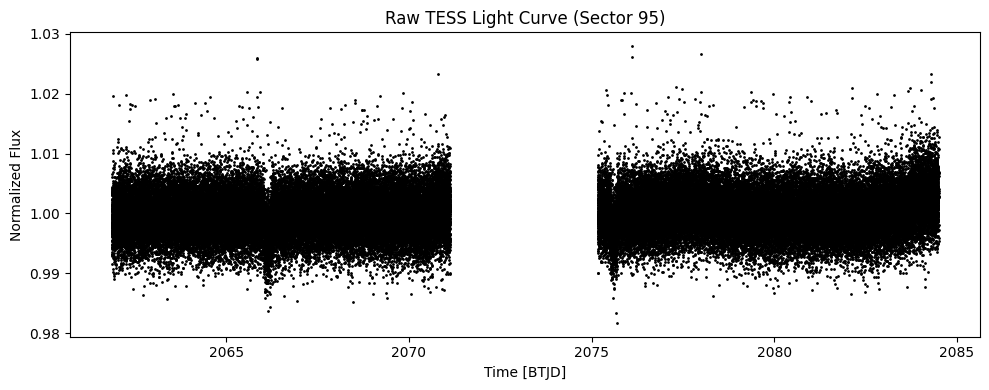

global sigma = 0.0037455856800079346 prominence min = 0.011236757040023804
找到的候选谷值个数: 190
候选时间: [2061.92809562 2062.04360504 2062.13064215 2062.22022552 2062.3431422
 2062.44337367 2062.54823473 2062.61906802 2062.72230868 2062.82786414
 2062.89892887 2062.99175283 2063.08133605 2063.15170631 2063.24545616
 2063.3734652  2063.46003911 2063.59939068 2063.67809421 2063.74776998
 2063.82670498 2063.90054739 2063.9998527  2064.08804691 2064.16582447
 2064.23642612 2064.36559241 2064.48711981 2064.57623989 2064.67971176
 2064.77855401 2064.87832217 2065.0010069  2065.10609909 2065.17716362
 2065.25031148 2065.33225558 2065.44475511 2065.55563425 2065.63688389
 2065.741976   2065.82716078 2065.92785474 2066.04660415 2066.13364075
 2066.20424224 2066.27530668 2066.38595424 2066.51465723 2066.58803645
 2066.72854491 2066.81257219 2066.94729361 2067.01997835 2067.10423709
 2067.21789378 2067.35145774 2067.4454386  2067.55539157 2067.65284461
 2067.73363109 2067.86534313 2067.94589811 2068.03200

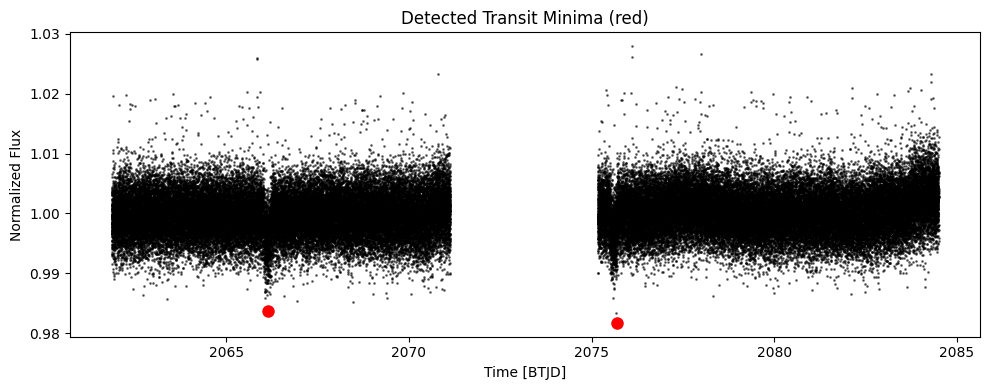

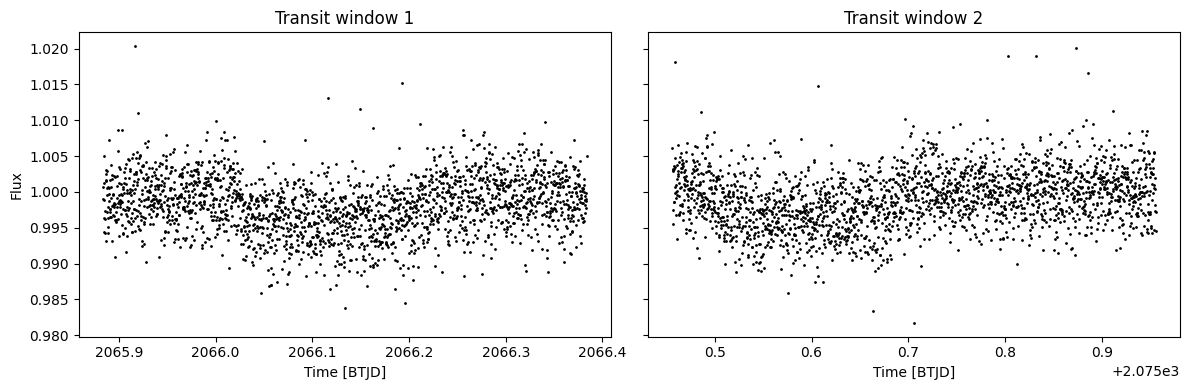

Fitting transit 1 ...


sample: 100%|██████████| 3500/3500 [03:36<00:00, 16.13it/s, 63 steps of size 2.80e-02. acc. prob=0.93] 


Posterior summary:
  t0        = 2066.320845 ± 0.009820
  duration  = 0.2581 ± 0.0293 days
  r (Rp/R*) = 0.0757 ± 0.0040
  b         = 0.6388 ± 0.2039
  c0        = 0.9962 ± 0.0002
  c1        = -0.0147 ± 0.0013
  sigma_jit = 0.00034 ± 0.00014
----------------------------------------

Fitting transit 2 ...


sample: 100%|██████████| 3500/3500 [03:58<00:00, 14.70it/s, 95 steps of size 2.67e-02. acc. prob=0.95] 


Posterior summary:
  t0        = 2075.841177 ± 0.005916
  duration  = 0.3329 ± 0.0124 days
  r (Rp/R*) = 0.0632 ± 0.0032
  b         = 0.3166 ± 0.2037
  c0        = 0.9968 ± 0.0002
  c1        = -0.0064 ± 0.0014
  sigma_jit = 0.00036 ± 0.00014
----------------------------------------

Transit 1 center time: 2066.320845 ± 0.009820
Transit 2 center time: 2075.841177 ± 0.005916
Difference (approx period): 9.520332 days


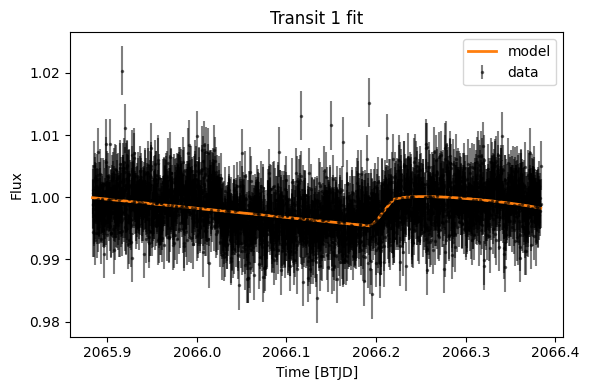

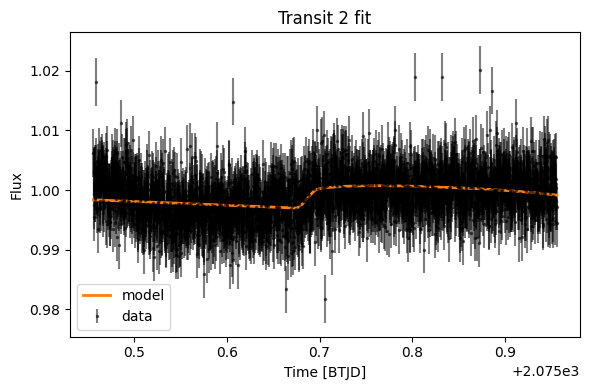

In [14]:
# ============================================
# 0. 导入依赖
# ============================================
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

from scipy.signal import find_peaks

# JAX 设置
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")

# ============================================
# 1. 取出 Sector 95 的真实光变
#    注意：download_sector 里 key 是 (sector, exptime)
# ============================================
lc = sector_data[(28, 20.0)]   # 如果 exptime 不是 120.0，这里改掉

time_np = lc.time.value       # BTJD
flux_np = lc.flux.value       # normalized flux

plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Raw TESS Light Curve (Sector 95)")
plt.tight_layout()
plt.show()

# ============================================
# 2. 用 prominence 找两个“最明显”的 transit 谷值
# ============================================
inv_flux = 1.0 - flux_np
sigma_all = float(np.std(flux_np))
prom_min = 3.0 * sigma_all

print("global sigma =", sigma_all, "prominence min =", prom_min)

peaks, props = find_peaks(
    inv_flux,
    distance=300,          # 两个 transit 至少隔这么多点
    prominence=prom_min    # 至少比周围高出 3σ
)

print("找到的候选谷值个数:", len(peaks))
print("候选时间:", time_np[peaks])

# 如果候选太少，自动放宽阈值
if len(peaks) < 2:
    prom_min = 2.0 * sigma_all
    print("候选 < 2，放宽 prominence 到", prom_min)
    peaks, props = find_peaks(
        inv_flux,
        distance=300,
        prominence=prom_min
    )
    print("新的候选个数:", len(peaks))
    print("新的候选时间:", time_np[peaks])

# 取 prominence 最大的两个（"prominences" 注意 s）
prom = props["prominences"]
order = np.argsort(prom)[::-1]
main_peaks = peaks[order[:2]]
main_peaks = np.sort(main_peaks)

idx1, idx2 = main_peaks
t0_guess1 = time_np[idx1]
t0_guess2 = time_np[idx2]

print("Transit candidates:", t0_guess1, t0_guess2)

# 可视化
plt.figure(figsize=(10,4))
plt.plot(time_np, flux_np, ".k", ms=2, alpha=0.5)
plt.plot(time_np[main_peaks], flux_np[main_peaks], "or", ms=8)
plt.xlabel("Time [BTJD]")
plt.ylabel("Normalized Flux")
plt.title("Detected Transit Minima (red)")
plt.tight_layout()
plt.show()

# ============================================
# 3. 按中心时间裁剪每个 transit 附近的一小段光变
# ============================================
def cut_transit(time_array, flux_array, t_center, window=0.25):
    """在 t_center 前后 window 天内裁剪光变."""
    mask = np.abs(time_array - t_center) < window
    t_cut = time_array[mask]
    f_cut = flux_array[mask]
    sigma_loc = float(np.std(f_cut))
    e_cut = np.ones_like(f_cut) * sigma_loc   # 把局部 std 当成名义误差
    return t_cut, f_cut, e_cut

t1, f1, e1 = cut_transit(time_np, flux_np, t0_guess1, window=0.25)
t2, f2, e2 = cut_transit(time_np, flux_np, t0_guess2, window=0.25)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axes[0].plot(t1, f1, ".k", ms=2)
axes[0].set_title("Transit window 1")
axes[1].plot(t2, f2, ".k", ms=2)
axes[1].set_title("Transit window 2")
for ax in axes:
    ax.set_xlabel("Time [BTJD]")
axes[0].set_ylabel("Flux")
plt.tight_layout()
plt.show()

# ============================================
# 4. 局部 transit 模型：transit + 很小的线性 baseline + jitter
#    参数：t0, duration, r, b, (固定 u1,u2), c0, c1, jitter
# ============================================
def transit_model_local(t, yerr, y=None):
    # t0：以局部窗口平均时间为中心
    t0 = numpyro.sample("t0", dist.Normal(t.mean(), 0.03))

    # duration：log-uniform 先验（0.08–0.35 d）
    logD = numpyro.sample("logD", dist.Uniform(jnp.log(0.08), jnp.log(0.35)))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # r: 半径比（不太可能 >0.25）
    r = numpyro.sample("r", dist.Uniform(0.02, 0.25))

    # b: impact parameter，避免 grazing，但也不要太死
    b = numpyro.sample("b", dist.Uniform(0.0, 0.8))

    # limb darkening：先固定成一个合理值，减少退化
    u1 = numpyro.deterministic("u1", 0.3)
    u2 = numpyro.deterministic("u2", 0.2)
    u = jnp.array([u1, u2])

    # 轨道：period=10 只是 dummy，用 duration/t0/b/r 控制形状
    orbit = TransitOrbit(
        period=10.0,
        duration=duration,
        time_transit=t0,
        impact_param=b,
        radius_ratio=r,
    )

    # limb_dark_light_curve 返回的是“被遮挡的光”(occultation)
    occultation = limb_dark_light_curve(orbit, u)(t)
    flux_tr = 1.0 - occultation

    # 很小的线性 baseline：c0 + c1*(t - t_center)
    t_center = t.mean()
    c0 = numpyro.sample("c0", dist.Normal(1.0, 0.005))
    c1 = numpyro.sample("c1", dist.Normal(0.0, 0.02))   # 斜率非常小
    baseline = c0 + c1 * (t - t_center)

    model = baseline * flux_tr

    # ========= jitter term =========
    med_err = jnp.median(yerr)
    log_sigma_jit = numpyro.sample(
        "log_sigma_jit",
        dist.Normal(jnp.log(med_err + 1e-8), 1.0)
    )
    sigma_jit = numpyro.deterministic("sigma_jit", jnp.exp(log_sigma_jit))
    sigma_tot = jnp.sqrt(yerr**2 + sigma_jit**2)

    numpyro.sample("obs", dist.Normal(model, sigma_tot), obs=y)

# ============================================
# 5. 拟合函数：返回 posterior 统计量 + samples
# ============================================
def fit_t0(time_array, flux_array, err_array, seed=0):
    t = jnp.array(time_array)
    f = jnp.array(flux_array)
    e = jnp.array(err_array)

    kernel = NUTS(transit_model_local)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2500, num_chains=1)
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(rng_key, t, e, y=f)
    samples = mcmc.get_samples()

    def mean_std(name):
        arr = np.array(samples[name])
        return float(arr.mean()), float(arr.std())

    t0_mean, t0_std = mean_std("t0")
    D_mean,  D_std  = mean_std("duration")
    r_mean,  r_std  = mean_std("r")
    b_mean,  b_std  = mean_std("b")
    c0_mean, c0_std = mean_std("c0")
    c1_mean, c1_std = mean_std("c1")
    sj_mean, sj_std = mean_std("sigma_jit")

    print("Posterior summary:")
    print(f"  t0        = {t0_mean:.6f} ± {t0_std:.6f}")
    print(f"  duration  = {D_mean:.4f} ± {D_std:.4f} days")
    print(f"  r (Rp/R*) = {r_mean:.4f} ± {r_std:.4f}")
    print(f"  b         = {b_mean:.4f} ± {b_std:.4f}")
    print(f"  c0        = {c0_mean:.4f} ± {c0_std:.4f}")
    print(f"  c1        = {c1_mean:.4f} ± {c1_std:.4f}")
    print(f"  sigma_jit = {sj_mean:.5f} ± {sj_std:.5f}")
    print("-" * 40)

    summary = dict(
        t0_mean=t0_mean, t0_std=t0_std,
        duration_mean=D_mean, duration_std=D_std,
        r_mean=r_mean, r_std=r_std,
        b_mean=b_mean, b_std=b_std,
        c0_mean=c0_mean, c0_std=c0_std,
        c1_mean=c1_mean, c1_std=c1_std,
        sigma_jit_mean=sj_mean, sigma_jit_std=sj_std,
    )
    return summary, samples

# ============================================
# 6. 分别拟合两次 transit 的中心时间 & 形状参数
# ============================================
print("Fitting transit 1 ...")
summary1, samples1 = fit_t0(t1, f1, e1, seed=1)

print("\nFitting transit 2 ...")
summary2, samples2 = fit_t0(t2, f2, e2, seed=2)

t0_1 = summary1["t0_mean"]
t0_2 = summary2["t0_mean"]
t0_1_std = summary1["t0_std"]
t0_2_std = summary2["t0_std"]

print("\n==============================")
print(f"Transit 1 center time: {t0_1:.6f} ± {t0_1_std:.6f}")
print(f"Transit 2 center time: {t0_2:.6f} ± {t0_2_std:.6f}")
print(f"Difference (approx period): {t0_2 - t0_1:.6f} days")
print("==============================")

# ============================================
# 7. 画一下每次拟合的局部 fit
# ============================================
def plot_fit(time_array, flux_array, t0_fit, samples, title):
    t = jnp.array(time_array)
    f = flux_array

    D_post  = float(np.mean(np.array(samples["duration"])))
    r_post  = float(np.mean(np.array(samples["r"])))
    b_post  = float(np.mean(np.array(samples["b"])))
    c0_post = float(np.mean(np.array(samples["c0"])))
    c1_post = float(np.mean(np.array(samples["c1"])))

    # limb darkening 固定
    u_post  = jnp.array([0.3, 0.2])

    orbit = TransitOrbit(
        period=10.0,
        duration=D_post,
        time_transit=t0_fit,
        impact_param=b_post,
        radius_ratio=r_post,
    )

    occultation = limb_dark_light_curve(orbit, u_post)(t)
    flux_tr = 1.0 - occultation

    t_center = t.mean()
    baseline = c0_post + c1_post * (t - t_center)

    model = np.array(baseline * flux_tr)

    plt.figure(figsize=(6,4))
    plt.errorbar(time_array, flux_array,
                 yerr=np.std(flux_array),
                 fmt=".k", ms=3, alpha=0.5, label="data")
    plt.plot(time_array, model, "-C1", lw=2, label="model")
    plt.xlabel("Time [BTJD]")
    plt.ylabel("Flux")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_fit(t1, f1, t0_1, samples1, "Transit 1 fit")
plot_fit(t2, f2, t0_2, samples2, "Transit 2 fit")
